In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

import networkx as nx

import argparse
import torch
import torch.nn as nn
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from torch.nn.parameter import Parameter
import torch.nn as nn
import math

from torch.autograd import grad
import pandas as pd
import seaborn as sns

from scipy.interpolate import griddata
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.decomposition import PCA

import itertools
from tqdm.auto import tqdm  # This is the recommended way

# Create Synthetic Data

In [ ]:
def burgers_equation(nx = 1000, nt=500, tmax=1.5, ub = 1.0, lb = -1.0, nu=0.1):
    """
    Solve the Burger's equation: du/dt + u*du/dx = nu*d^2u/dx^2
    using implicit finite difference method

    Parameters:
        nx: number of spatial points
        nt: number of time steps
        tmax: maximum time
        ub: upper bound of the spatial domain
        lb: lower bound of the spatial domain
        nu: viscosity coefficient
    """
    # Set up grid
    L = ub - lb
    dx = L/nx
    dt = tmax/nt
    x = np.linspace(lb, ub, nx)
    t = np.linspace(0, tmax, nt)

    # Initialize solution array
    u = np.zeros((nt, nx))

    # Initial condition (sinusoidal wave)
    u[0, :] = -np.sin(np.pi*x)

    # Create sparse matrices for implicit scheme
    r = nu*dt/(dx**2)

    for n in range(0, nt-1):
        # Create coefficient matrix A_tilde
        main_diag = 1 + 2*r * np.ones(nx)
        upper_diag = -r * np.ones(nx-1)
        lower_diag = -r * np.ones(nx-1)

        A_tilde = diags([main_diag, upper_diag, lower_diag], [0, 1, -1], format='csr')

        # Create RHS vector
        b = u[n, :] - dt/(2*dx) * u[n, :] * (np.roll(u[n, :], -1) - np.roll(u[n, :], 1))

        # Apply periodic boundary conditions
        b[0] = u[n, 0]
        b[-1] = u[n, -1]

        # Solve system
        u[n+1, :] = spsolve(A_tilde, b)

    return x, t, u

def plot_solution(x, t, u):
    """Plot the solution as a 2D heatmap and final time snapshot"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # Plot heatmap
    im = ax1.pcolormesh(x, t, u, shading='auto')
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_title("Burger's equation solution")
    plt.colorbar(im, ax=ax1)

    # Plot final time solution
    ax2.plot(x, u[-1, :], 'b-', label='Final time')
    ax2.plot(x, u[0, :], 'r--', label='Initial condition')
    ax2.set_xlabel('x')
    ax2.set_ylabel('u')
    ax2.legend()
    ax2.set_title('Solution at final time')

    plt.tight_layout()
    plt.show()

# Generate and plot solution
x, time, u = burgers_equation()

In [ ]:
np.random.seed(42)

u_rand = u + np.random.normal(0, 0.1, u.shape)
#u_rand = u

# Get node locations

In [ ]:
n_nodes = 30

np.random.seed(42)

x_node = np.random.choice(x, n_nodes, replace=False)

x_node_indeces = np.where(np.isin(x,x_node))[0]

velocity = u_rand[:,x_node_indeces]

Text(0.5, 1.0, 'node locations')

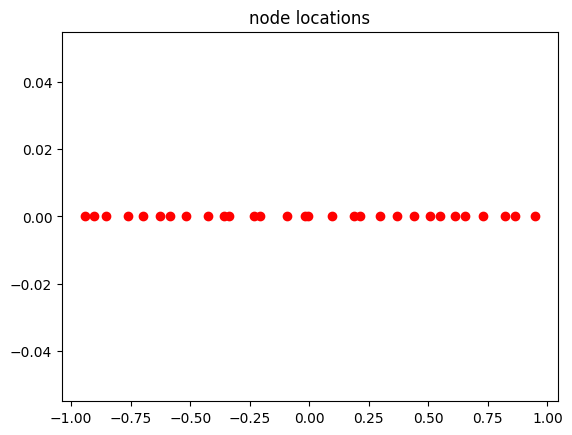

In [ ]:
plt.plot(x_node, np.zeros(len(x_node)), "ro")
plt.title("node locations")

# Get adjacency matrix

In [ ]:
def adjacency_matrix(data, x_node, window_size=5, alpha=0.5, threshold = 0.4):
    """
    Enhanced adjacency matrix construction incorporating both spatial and temporal correlations

    Args:
        data: velocity data of shape [t, n_nodes]
        x_node: spatial coordinates of nodes
        window_size: window for temporal correlation
        alpha: weight between spatial and temporal correlation
        spatial_threshold: threshold for spatial connections
        temporal_threshold: threshold for temporal connections
    """
    n_nodes = len(x_node)

    Ws = np.exp(-(x_node[:,np.newaxis] - x_node)**2/np.std(x_node)) - np.eye(len(x_node))

    # Combine spatial and temporal correlations
    A = Ws

    threshold = 1.0

    A_temp = A.copy()
    A_temp[A<=threshold] = 0

    G = nx.Graph(A_temp)

    while not nx.is_connected(G) and threshold>=0:

        threshold -= 0.01
        A_temp = A.copy()
        A_temp[A<=threshold] = 0
        G = nx.Graph(A_temp)

    return A_temp, threshold

In [ ]:
A, threshold = adjacency_matrix(velocity, x_node)

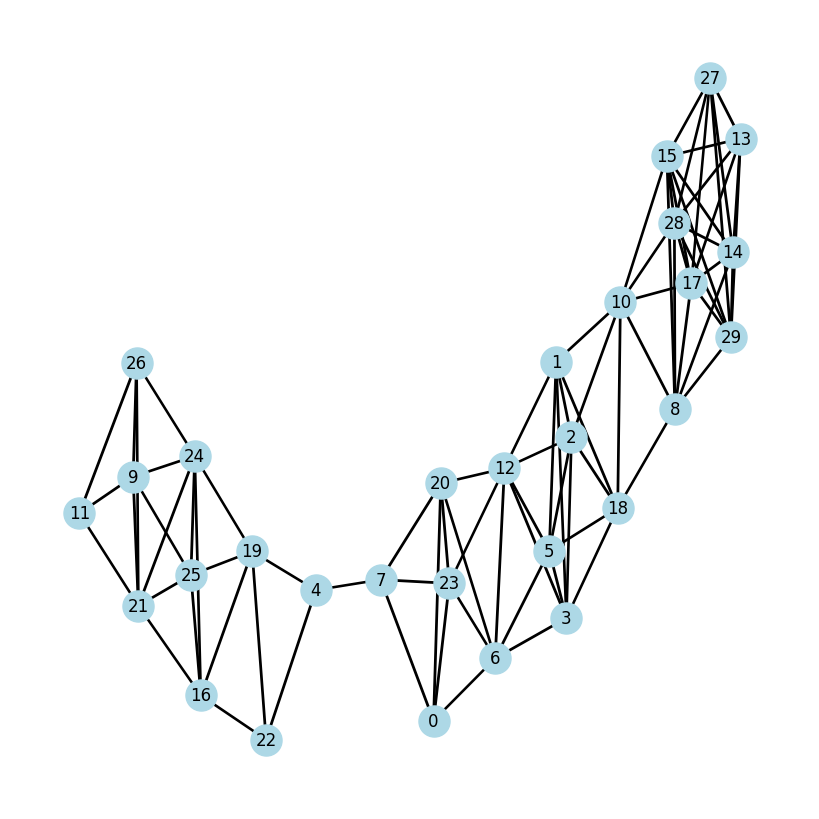

In [ ]:
G = nx.from_numpy_array(A)

# Generate node positions
pos = nx.kamada_kawai_layout(G)

# Rotate the graph by 90 degrees by swapping x and y coordinates
rotated_pos = {node: (y, -x) for node, (x, y) in pos.items()}  # Swap and negate y for 90-degree rotation

# Edge widths proportional to weights
weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]  # Multiply by 2 to make more visible

# Plot the rotated graph
plt.figure(figsize=(8, 8))
nx.draw(G, rotated_pos, width=weights, with_labels=True,
        node_color='lightblue', node_size=500)
plt.show()

# Create train, validation and test data

This section initially chooses the nodes and time periods in which I have missing data. For the training data, the block_mask function create a mask of missing (0) and available (1) data by randomly choosing the nodes that will have missing data; if a node is chosen, the function also randomly chooses the time period in which the data is missing. Then, I do the same for the validation set and the test set. However, in the validation set only the nodes that were not chosen to have a missing value in the training set are chosen to have a missing value. Then, I create the test set chosing the possible nodes for missing values that were not chosen in training and validation. This procedure reduce data leakage problem.
This masks are then used to create the data. For each time step I create the adjacency matrix $ \hat{A} = \tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2} $ where $\tilde{A} = A + I$ and $\tilde{D} = diag(\sum_{i=1}^{N_{node}} (A_{bin})_i)$ that is the degree matrix, it counts the number of edges linked to a node, $A_{bin}$ is the binary adjacency matrix where the element $A_{ij} = 1$ if node i and j are linked. The adjacency matrix is then multiplied by the mask, setting the rows and columns corresponding to nodes with missing values at that time step to zero. This effectively detaches the node from the graph, preventing it from sending or receiving information from other nodes. Then the missing velocities are set to zero and the mask take the value of -Inf in correspondence to the missing values, this is done to



In [ ]:
def block_mask_test(set_size, n_nodes, possible_nodes):

    mask = torch.ones((set_size, n_nodes), dtype = torch.int)
    max_length_masked = set_size/2

    node_seen = []

    #for node in possible_nodes:
    for node in range(n_nodes):

      if np.random.binomial(1,0.3) == 1:

        random_length = np.random.randint(0, max_length_masked)
        init_val = np.random.randint(0, set_size)
        node_seen.append(node)
        mask[init_val:init_val+random_length, node] = 0

    return mask


In [ ]:
def block_mask(train_size, val_size, test_size, n_nodes):

  mask_train = torch.ones((train_size, n_nodes), dtype = torch.int)

  max_length_masked_train = train_size/4

  node_seen_train = []
  for node in range(n_nodes):

    if np.random.binomial(1,0.5) == 1: # Chose the node as node masked
      random_length = np.random.randint(0, max_length_masked_train) # Chose the time frame of node's non availability
      init_val = np.random.randint(0,train_size) # Chose the time step from when the node start to be non avilable
      node_seen_train.append(node)
      mask_train[init_val:init_val+random_length, node] = 0 # Set to zero the period of node's non availability

  #masked_nodes_train = [np.where(mask_train[t,:] == 0)[0] for t in range(train_size)] # list of node masked at each time step in training set

  total_masked = np.unique(node_seen_train) # list of unique node masked

  possible_choice_masked_nodes = np.where(~np.isin(np.arange(n_nodes), total_masked))[0] # chose nodes to mask in test set that has never been mask

  sep = int(len(possible_choice_masked_nodes)/2)
  possible_nodes_val = possible_choice_masked_nodes[:sep]
  possible_nodes_test = possible_choice_masked_nodes[sep:]

  mask_val = block_mask_test(val_size, n_nodes, possible_nodes_val)

  mask_test = block_mask_test(test_size, n_nodes, possible_nodes_test)

  return mask_train, mask_val, mask_test #, masked_nodes_train, masked_nodes_test

In [ ]:
def get_A_hat(adj):
  A_tilde = torch.tensor(adj, dtype = torch.float32) + torch.eye(adj.shape[0], dtype = torch.float32)

  # computing D_tilde, D_tilde_inv and D_tilde_inv**(1/2)
  A_bin = A_tilde.clone()
  A_bin[A_bin!=0] = 1
  D_tilde = np.array(torch.diag(torch.sum(A_bin, axis = 1)))
  D_tilde_inv = np.linalg.inv(D_tilde)
  D_tilde_inv_sqrt = np.sqrt(D_tilde_inv)
  D_tilde_inv_sqrt[~np.isfinite(D_tilde_inv_sqrt)] = 0
  D_tilde_inv_sqrt = torch.tensor(D_tilde_inv_sqrt, dtype = torch.float32)

  # final adjacency matrix
  A_hat = D_tilde_inv_sqrt@A_tilde@D_tilde_inv_sqrt

  return A_hat



In [ ]:
def create_data(data, A, mask, set_size):

  mask = mask.clone()

  mask = [torch.tensor(mask[tt,:], dtype = torch.float32) for tt in range(set_size)]
  masked_nodes = [np.where(mask[tt]==0)[0] for tt in range(set_size)]
  unmasked_nodes = [np.where(~np.isin(np.arange(len(x_node)), mm))[0] for mm in masked_nodes]

  # #obscured_node_index = [np.where(np.array(mask[i])==-float("Inf"))[0] for i in range(len(t))]

  A_list = []
  X_list = []
  mask_list = []

  V_temp = data.clone()
  A_temp = A.clone()

  #inductive nodes, I remove masked nodes. Note that the weight matrix in message passing does not depend on the number of nodes, so I can learn it on a graph with N nodes and test it on a graph with N2 nodes

  for i in range(set_size):

        m = mask[i]

        A_temp = A_temp*m*m.unsqueeze(1) # set the corresponding row and column of masked index to zero in order to detach the node with missing values from the graph
        A_temp[masked_nodes[i],masked_nodes[i]] = A[masked_nodes[i],masked_nodes[i]] # allow self loop even to nodes with missing values

        A_hat = get_A_hat(A_temp)

        V_temp[i,masked_nodes[i]]= torch.mean(data[i,:])


        mask[i][masked_nodes[i]] = -float("Inf")  # nodes with missing velocities set to -Inf

        A_list.append(A_hat)
        mask_list.append(mask[i])


  A_list = [a.float() for a in A_list]
  V_temp = V_temp.float()
  mask_list = [m.float() for m in mask_list]
  masked_nodes = [torch.tensor(mm, dtype = torch.long) for mm in masked_nodes]
  unmasked_nodes = [torch.tensor(mm, dtype = torch.long) for mm in unmasked_nodes]

  return (A_list, V_temp, mask_list, masked_nodes, unmasked_nodes)

In [ ]:
def train_test_split(data, A, train_size, val_size, test_size, n_nodes):

  #vel = data_tot[:,:,-1].reshape(500,30)

  mask_train, mask_val, mask_test = block_mask(train_size, val_size, test_size, n_nodes)

  vel_train = data.clone()
  vel_train = vel_train[:train_size, :]
  train = create_data(vel_train, torch.tensor(A), mask_train, train_size)

  vel_val = data.clone()
  vel_val = vel_val[train_size:train_size+val_size, :]
  val = create_data(vel_val, torch.tensor(A), mask_val, val_size)

  vel_test = data.clone()
  vel_test = vel_test[-test_size:, :]
  test = create_data(vel_test, torch.tensor(A), mask_test, test_size)

  vel_train_val = data.clone()
  vel_train_val = vel_train_val[:train_size+val_size, :]
  mask_train_val = torch.cat((mask_train, mask_val), dim = 0)
  train_val = create_data(vel_train_val, torch.tensor(A), mask_train_val, train_size+val_size)

  return train, val, test, train_val



In [ ]:
np.random.seed(42)

# combination position and time
T,X = np.meshgrid(time, x_node)

data_vel = torch.tensor(velocity, dtype = torch.float32)

train_size = 400
val_size = 50
test_size = 50

out_data_train, out_data_val, out_data_test, out_data_train_val = train_test_split(data_vel, torch.tensor(A), train_size, val_size, test_size, n_nodes)



<ipython-input-164-844463d39344>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train = create_data(vel_train, torch.tensor(A), mask_train, train_size)
<ipython-input-163-f04a51e9b0fd>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = [torch.tensor(mask[tt,:], dtype = torch.float32) for tt in range(set_size)]
<ipython-input-162-b9855a1932ce>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_tilde = torch.tensor(adj, dtype = torch.float32) + torch.eye(adj.shape[0], dtype = torch.float32)
<ipython-input-164-844463d39344>:13: UserWa

Text(0.5, 1.0, 'train mask')

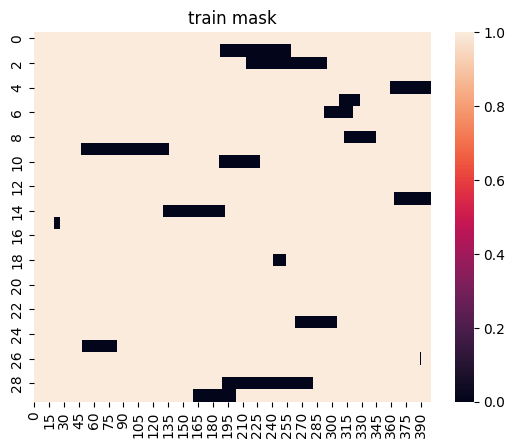

In [ ]:
bin_mask_train = torch.stack(out_data_train[2])
bin_mask_train[bin_mask_train==-float("Inf")] = 0
sns.heatmap(bin_mask_train.T)
plt.title("train mask")

Text(0.5, 1.0, 'validation mask')

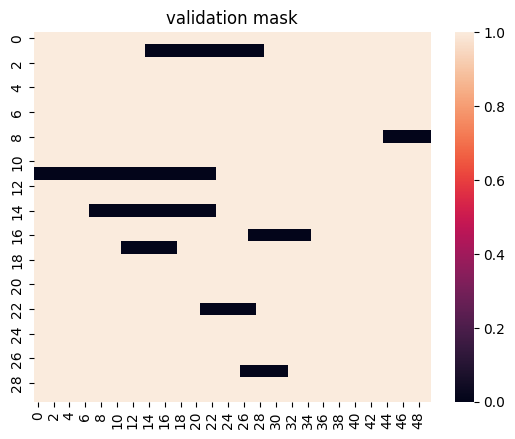

In [ ]:
bin_mask_val = torch.stack(out_data_val[2])
bin_mask_val[bin_mask_val==-float("Inf")] = 0
sns.heatmap(bin_mask_val.T)
plt.title("validation mask")

In [ ]:
((50*30)-torch.sum(bin_mask_val))/(50*30)

tensor(0.0500)

Text(0.5, 1.0, 'test mask')

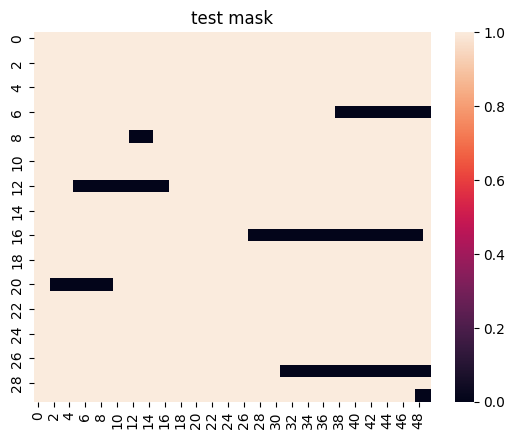

In [ ]:
bin_mask_test = torch.stack(out_data_test[2])
bin_mask_test[bin_mask_test==-float("Inf")] = 0
sns.heatmap(bin_mask_test.T)
plt.title("test mask")

Text(0.5, 1.0, 'test mask')

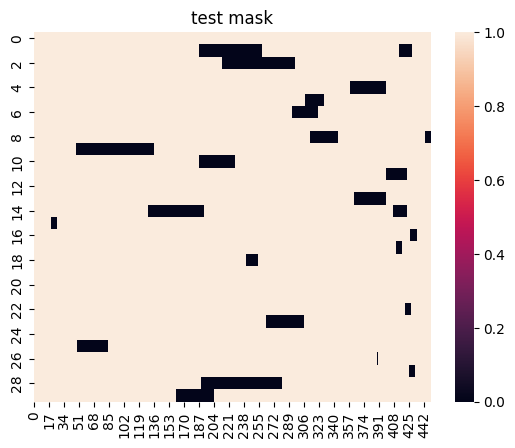

In [ ]:
bin_mask_train_val = torch.stack(out_data_train_val[2])
bin_mask_train_val[bin_mask_train_val==-float("Inf")] = 0
sns.heatmap(bin_mask_train_val.T)
plt.title("test mask")

In [ ]:
((50*30)-torch.sum(bin_mask_test))/(50*30)

tensor(0.0347)

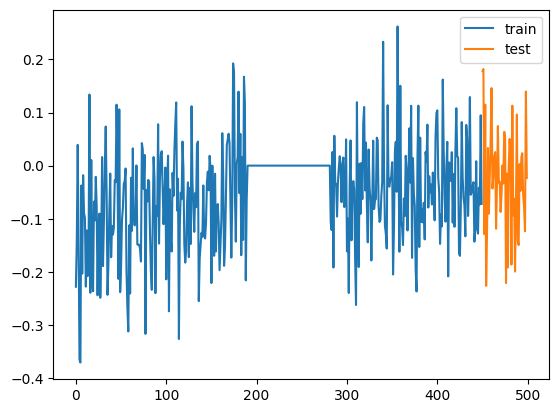

In [ ]:
plt.plot(np.arange(train_size+val_size),out_data_train_val[1][:,28], label = "train")
plt.plot(np.arange(train_size+val_size,500),out_data_test[1][:,28], label = "test")
plt.legend()

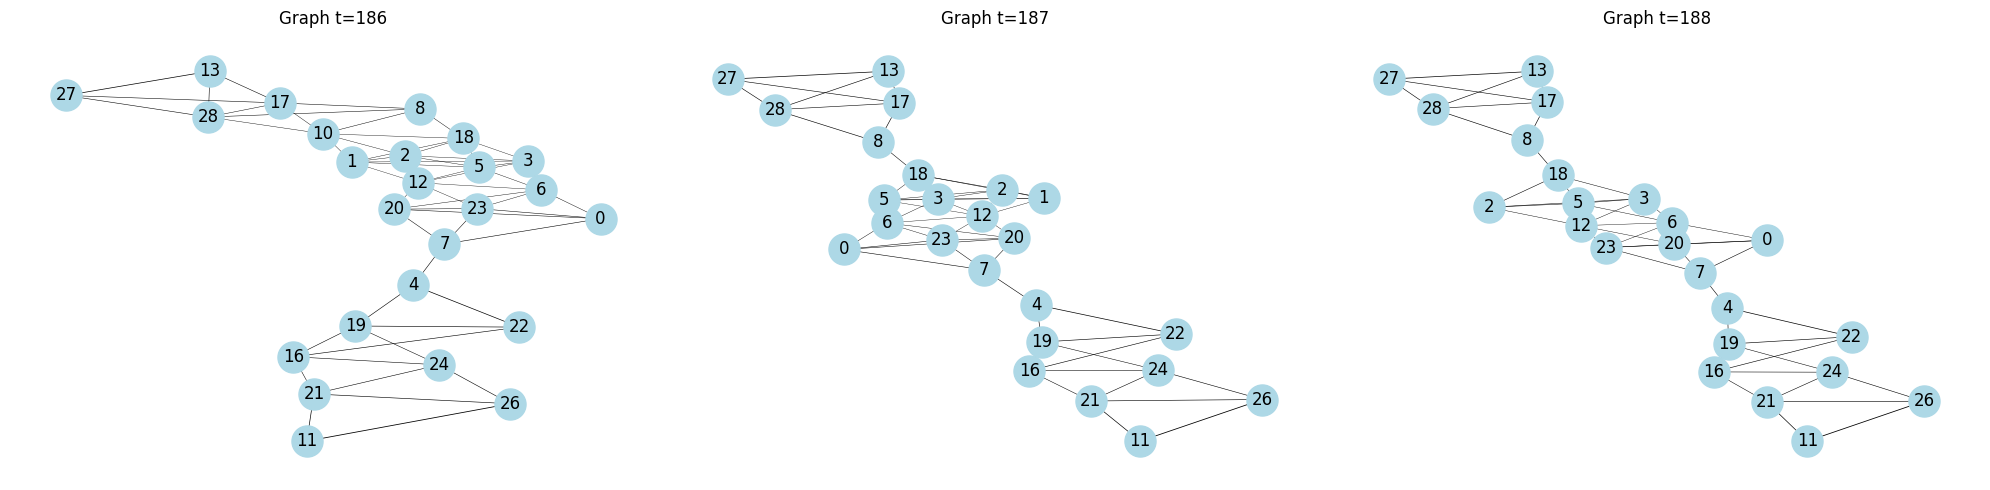

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

axes = [ax1, ax2, ax3]

for i, e in enumerate(range(186, 189)):

    A_temp = out_data_train_val[0][e].clone()
    A_temp[range(A_temp.size(0)), range(A_temp.size(1))] = torch.zeros(A_temp.size(0))
    G = nx.from_numpy_array(np.array(A_temp))
    G.remove_nodes_from(A_temp)

    # Remove isolated nodes
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)

    pos = nx.kamada_kawai_layout(G)
    # Edge widths proportional to weights
    weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]  # Multiply by 2 to make more visible
    nx.draw(
        G, pos, ax=axes[i], width=weights, with_labels=True,
        node_color='lightblue', node_size=500
    )
    axes[i].set_title(f"Graph t={e}")

plt.tight_layout()  # Prevent overlap
plt.show()



# Model Architecture

In [ ]:
def pad_with_last_val(vect, k):
    device = vect.device  # Get device directly from tensor
    pad = torch.ones(k - vect.size(0),
                    dtype=torch.long,
                    device=device) * vect[-1]
    vect = torch.cat([vect, pad])
    return vect

# Fix the pad_with_zeros function similarly
def pad_with_zeros(vect, n):
    device = vect.device  # Get device directly from tensor
    pad = torch.zeros(n - vect.size(0),
                     dtype=torch.long,
                     device=device)
    vect = torch.cat([vect, pad])
    return vect

class Namespace(object):
    '''
    helps referencing object in a dictionary as dict.key instead of dict['key']
    '''
    def __init__(self, adict):
        self.__dict__.update(adict)


class EGCN(torch.nn.Module):
    def __init__(self, args, activation, device='cpu', skipfeats=False):
        super().__init__()
        GRCU_args = Namespace({})

        feats = [args.feats_per_node,
                 args.layer_1_feats,
                 args.layer_2_feats,
                 args.layer_3_feats,
                 ]
        self.device = device
        self.skipfeats = skipfeats

        self.GRCU_layers = nn.ModuleList()
        for i in range(1, len(feats)):
            GRCU_args = Namespace({'in_feats': feats[i - 1],
                                   'out_feats': feats[i],
                                   'activation': activation})

            grcu_i = GRCU(GRCU_args)
            self.GRCU_layers.append(grcu_i.to(self.device))

    def forward(self, A_list, Nodes_list, nodes_mask_list):
        node_feats = Nodes_list[-1]

        for unit in self.GRCU_layers:
            Nodes_list, weights = unit(A_list, Nodes_list, nodes_mask_list)

        if self.skipfeats:
            out = torch.cat((Nodes_list[-1], node_feats), dim=1)  # Use `node_feats.to_dense()` if 2-hot encoded input
        return Nodes_list, weights

class GRCU(torch.nn.Module):
    def __init__(self,args):
        super().__init__()
        self.args = args
        cell_args = Namespace({})
        cell_args.rows = args.in_feats
        cell_args.cols = args.out_feats

        self.evolve_weights = mat_GRU_cell(cell_args)

        self.activation = self.args.activation
        self.GCN_init_weights = Parameter(torch.Tensor(self.args.in_feats,self.args.out_feats))
        self.reset_param(self.GCN_init_weights)


    def reset_param(self,t):
        #Initialize based on the number of columns
        stdv = 1. / math.sqrt(t.size(1))
        t.data.uniform_(-stdv,stdv)

    def forward(self,A_list,node_embs_list,mask_list):
        GCN_weights = self.GCN_init_weights
        out_seq = []
        weights = []
        for t,Ahat in enumerate(A_list):
            node_embs = node_embs_list[t]
            #first evolve the weights from the initial and use the new weights with the node_embs

            GCN_weights = self.evolve_weights(GCN_weights,node_embs,mask_list[t])

            weights.append(GCN_weights.detach().cpu().numpy())

            node_embs = self.activation(Ahat.matmul(node_embs.matmul(GCN_weights)))

            out_seq.append(node_embs)

        return out_seq, weights

class mat_GRU_cell(torch.nn.Module):
    def __init__(self,args):
        super().__init__()
        self.args = args
        self.update = mat_GRU_gate(args.rows,
                                   args.cols,
                                   torch.nn.Sigmoid())

        self.reset = mat_GRU_gate(args.rows,
                                   args.cols,
                                   torch.nn.Sigmoid())

        self.htilda = mat_GRU_gate(args.rows,
                                   args.cols,
                                   torch.nn.ReLU())

        self.choose_topk = TopK(feats = args.rows,
                                k = args.cols )

    def forward(self,prev_Q,prev_Z,mask):
        z_topk = self.choose_topk(prev_Z,mask)

        update = self.update(z_topk,prev_Q)
        reset = self.reset(z_topk,prev_Q)

        h_cap = reset * prev_Q
        h_cap = self.htilda(z_topk, h_cap)

        new_Q = (1 - update) * prev_Q + update * h_cap

        return new_Q



class mat_GRU_gate(torch.nn.Module):
    def __init__(self,rows,cols,activation):
        super().__init__()
        self.activation = activation
        #the k here should be in_feats which is actually the rows
        self.W = Parameter(torch.Tensor(rows,rows))
        self.reset_param(self.W)

        self.U = Parameter(torch.Tensor(rows,rows))
        self.reset_param(self.U)

        self.bias = Parameter(torch.zeros(rows,cols))

    def reset_param(self,par):
        #Initialize based on the number of columns
        stdv = 1. / math.sqrt(par.size(1))
        par.data.uniform_(-stdv,stdv)

    def forward(self,x,hidden):
        out = self.activation(self.W.matmul(x) + \
                              self.U.matmul(hidden) + \
                              self.bias)

        return out

class TopK(torch.nn.Module):
    def __init__(self,feats,k):
        super().__init__()
        self.scorer = Parameter(torch.Tensor(feats,1))
        self.reset_param(self.scorer)

        self.k = k

    def reset_param(self,par):
        #Initialize based on the number of rows
        stdv = 1. / math.sqrt(par.size(0))
        par.data.uniform_(-stdv,stdv)


    def forward(self, node_embs, mask):
        # # Compute scores

        scores = node_embs.matmul(self.scorer) / self.scorer.norm()
        scores = scores + mask.view(-1, 1)
        num_nodes = node_embs.size(0)

        if self.k <= num_nodes:
            vals, topk_indices = scores.view(-1).topk(self.k)
            topk_indices = topk_indices[vals > -float("Inf")]

            if topk_indices.size(0) < self.k:
                topk_indices = pad_with_last_val(topk_indices, self.k)

            selected_nodes = node_embs[topk_indices]
            selected_scores = scores[topk_indices]

        else:
            vals, topk_indices = scores.view(-1).topk(num_nodes)
            valid_mask = vals > -float("Inf")
            topk_indices = topk_indices[valid_mask]

            if topk_indices.size(0) < self.k:
                topk_indices = pad_with_last_val(topk_indices, self.k)

            selected_nodes = node_embs[topk_indices]
            selected_scores = scores[topk_indices]
            remaining_k = self.k - topk_indices.size(0)

            if remaining_k > 0:
                vals, sorted_indices = scores.view(-1).sort(descending=True)
                valid_mask = vals > -float("Inf")
                sorted_indices = sorted_indices[valid_mask]

                if remaining_k <= num_nodes:
                    repeat_indices = sorted_indices[:remaining_k]
                else:
                    repeat_times = (remaining_k + num_nodes - 1) // num_nodes
                    repeat_indices = sorted_indices.repeat(repeat_times)[:remaining_k]

                if repeat_indices.size(0) < remaining_k:
                    repeat_indices = pad_with_last_val(repeat_indices, remaining_k)

                repeated_nodes = node_embs[repeat_indices]
                repeated_scores = scores[repeat_indices]

                selected_nodes = torch.cat([selected_nodes, repeated_nodes], dim=0)
                selected_scores = torch.cat([selected_scores, repeated_scores], dim=0)

        tanh = torch.nn.Tanh()
        out = selected_nodes * tanh(selected_scores.view(-1, 1))
        return out.t()


class LearnableAttention(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()

        #Neural network to compute attention scores
        self.attention_net = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),  # Concatenated embeddings as input
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, query_embedding, key_embeddings):
        """
        Args:
            query_embedding: embedding of the node with missing value (1, embedding_dim)
            key_embeddings: embeddings of the neighbor nodes (k, embedding_dim)
        Returns:
            attention_weights: (k,)
        """
        # Repeat query embedding for each key
        query_expanded = query_embedding.unsqueeze(0).expand(key_embeddings.shape[0], -1)

        # Concatenate query and key embeddings
        combined = torch.cat([query_expanded, key_embeddings], dim=1)

        # Compute attention scores
        scores = self.attention_net(combined)

        # Normalize scores using softmax
        attention_weights = F.softmax(scores.squeeze(-1), dim=0)

        return attention_weights



class PredictionEGCN(nn.Module):
    def __init__(self, args, activation, n_nodes, device, p_dropout, k):
        super().__init__()

        # hidden_layers = domain_search["hidden_layers"]
        # p_dropout = domain_search["p_dropout"]

        self.k = k
        self.args = args
        self.device = device
        self.n_nodes = n_nodes
        self.embedding = EGCN(args, activation, device)

        # Increased network capacity with attention and skip connections
        hidden_dim = self.args.layer_3_feats * self.n_nodes

        self.node_specific_nn = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, 128, bias = False),
                                                             nn.LeakyReLU(),
                                                             nn.Dropout(p_dropout),
                                                             nn.Linear(128, 64, bias = False),
                                                             nn.LeakyReLU(),
                                                             nn.Dropout(p_dropout),
                                                             nn.Linear(64,30, bias = False)) for _ in range(len(time))])

        self.attention = LearnableAttention(args.layer_3_feats, args.layer_3_feats)

    #     self.apply(self._init_weights)

    # def _init_weights(self, m):
    #     if isinstance(m, nn.Linear):
    #         nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

    def l2_regularization(self, rate):

        l2_loss = 0

        for param in self.parameters():
            l2_loss += torch.norm(param, 2)

        return rate * l2_loss


    def impute_missing_values(self, predictions, embed_mat, missing_nodes, k):
        """
        Impute missing values using learnable attention
        """
        if len(missing_nodes) == 0:
            return predictions

        # Compute similarity for KNN
        similarity_nodes = torch.cdist(embed_mat, embed_mat)
        similarity_nodes.fill_diagonal_(float('inf'))
        _, nearest_indices = torch.topk(similarity_nodes, k=1, largest=False)

        imputed_predictions = predictions.clone()

        for idx in missing_nodes:
            # Get embeddings
            query_embed = embed_mat[idx]
            neighbor_embeds = embed_mat[nearest_indices[idx]]

            # Compute attention weights using learnable attention
            attention_weights = self.attention(query_embed, neighbor_embeds)

            # Compute weighted prediction
            imputed_value = (predictions[nearest_indices[idx]] * attention_weights).sum()
            imputed_predictions[idx] = imputed_value

        return imputed_predictions

    def forward(self, A_list, g, vel, nodes_mask_list):

        dummy_mask = torch.stack(nodes_mask_list)
        dummy_mask[dummy_mask==-float("Inf")] = 0
        time_size = len(A_list)
        gg = torch.cat((g.reshape(time_size,30,2), vel.reshape(-1,1).reshape(time_size,30,1)),dim = 2) # dummy_mask.reshape(-1,1).reshape(time_size,30,1)), dim = 2)
        Nodes_list = [g for g in gg]
        final_embed, weights = self.embedding(A_list, Nodes_list, nodes_mask_list)
        prediction_for_each_t = []
        embed_mat_list = []


        # Process each timestep
        for i in range(len(final_embed)):
            embed_mat = final_embed[i]
            embed_mat_list.append(embed_mat)
            embed = embed_mat.flatten().unsqueeze(0)
            pred = self.node_specific_nn[i](embed).reshape(-1)
            prediction_for_each_t.append(pred)

            if len(torch.where(nodes_mask_list[i]==1)[0]) < len(nodes_mask_list[i]):
                missing_nodes = torch.where(nodes_mask_list[i] == -float("Inf"))[0]
                pred = self.impute_missing_values(pred, embed_mat, missing_nodes, self.k)

        return prediction_for_each_t, weights, embed_mat_list


In [ ]:
class PredictionReadOut(nn.Module):
    def __init__(self, args, n_nodes, device,  p_dropout):
        super().__init__()

        self.args = args
        self.device = device
        self.n_nodes = n_nodes

        hidden_dim = self.args.feats_per_node * self.n_nodes

        self.node_specific_nn = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, 128, bias = True),
                                                             nn.ReLU(),
                                                             nn.Dropout(p_dropout),
                                                             nn.Linear(128, 64, bias = True),
                                                             nn.ReLU(),
                                                             nn.Dropout(p_dropout),
                                                             nn.Linear(64,30, bias = True)) for _ in range(len(time))])

    def forward(self, g, vel, nodes_mask_list):

        dummy_mask = torch.stack(nodes_mask_list)
        dummy_mask[dummy_mask==-float("Inf")] = 0
        time_size = len(nodes_mask_list)
        gg = torch.cat((g.reshape(time_size,30,2), vel.reshape(-1,1).reshape(time_size,30,1), dummy_mask.reshape(-1,1).reshape(time_size,30,1)), dim = 2)
        Nodes_list = [g for g in gg]
        prediction_for_each_t = []
        embed_mat = []


        # Process each timestep
        for i in range(len(Nodes_list)):
            embed = Nodes_list[i]
            embed = embed.flatten().unsqueeze(0)
            pred = self.node_specific_nn[i](embed).reshape(-1)
            prediction_for_each_t.append(pred)

        return prediction_for_each_t

# Fine Tuning

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

args_dict = Namespace({
        'feats_per_node': 3,
        'layer_1_feats': 16,
        'layer_2_feats': 16,
        'layer_3_feats': 8,
        }) # output dim

activation = nn.ReLU()

A_list_train = [a.to(device) for a in out_data_train[0]]
mask_list_train = [m.to(device) for m in out_data_train[2]]
missing_nodes_train = [nm.to(device) for nm in out_data_train[3]]
velocity_train = data_vel[:train_size,:].to(device)

A_list_val = [a.to(device) for a in out_data_val[0]]
mask_list_val = [m.to(device) for m in out_data_val[2]]
missing_nodes_val = [nm.to(device) for nm in out_data_val[3]]
velocity_val = data_vel[train_size:train_size+val_size,:].to(device)

tt_train = torch.tensor(time[:train_size], dtype = torch.float32).to(device)
xx = torch.tensor(x_node, dtype = torch.float32).to(device)
g_train = torch.stack(torch.meshgrid(tt_train, xx)).reshape(2,-1).T.requires_grad_(True).to(device)
vel_train = out_data_train[1].to(device)

tt_val = torch.tensor(time[train_size:train_size+val_size], dtype = torch.float32).to(device)
xx = torch.tensor(x_node, dtype = torch.float32).to(device)
g_val = torch.stack(torch.meshgrid(tt_val, xx)).reshape(2,-1).T.requires_grad_(True).to(device)
vel_val = out_data_val[1].to(device)

n_nodes = len(x_node)

prev_epoch_loss = torch.tensor(float("Inf"))
counter = 0

n_epochs = 20

lambda_physics = 0.3

train_data_loss = []
train_loss = []
test_loss = []
train_loss_physics = []
val_loss = []

nu = 0.1

p_dropout = np.linspace(0,1,10)

dict_perf = {"error on missing val":[],
             "error on available val": []}


lowest_error = float("Inf")


#for config in tqdm(all_configs[:10], desc="Testing Configurations", unit="config"):

#for p in p_dropout:
  #print(f"p: {p}")
model = PredictionEGCN(args_dict, activation, n_nodes, device, 0.55, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay = 0.01)
model.train()

for epoch in range(n_epochs):
    epoch_loss = 0
    predictions_t = []

    optimizer.zero_grad()

    predictions, weights, _ = model.forward(A_list_train, g_train, vel_train, mask_list_train)

    uu = torch.stack(predictions).reshape(-1)

    du_dg = torch.autograd.grad(
          inputs=g_train,
          outputs=uu,
          grad_outputs=torch.ones_like(uu),
          retain_graph=True,
          create_graph=True
      )[0]

    du_dt = du_dg[:,0]
    du_dx = du_dg[:,1]

    du_dxx = torch.autograd.grad(
          inputs=g_train,
          outputs=du_dg,
          grad_outputs=torch.ones_like(du_dg),
          retain_graph=True,
          create_graph=True
      )[0][:, 0]



    f = uu*du_dx + du_dt - nu*du_dxx

    physics_loss = F.mse_loss(f,torch.zeros_like(f))

    train_loss_physics.append(physics_loss.detach().item())


    data_loss = 0
    missing_train = 0
    count_missing = 0
    count_available = 0
    available_train = 0
    imputation_loss = 0



    for i in range(train_size):
        mask = mask_list_train[i].clone()
        mask[mask==-float("Inf")] = 0

        # Data loss for available values
        data_loss += F.mse_loss(predictions[i][mask==1], velocity_train[i,:][mask==1])

        # Imputation for missing values during training
        if missing_nodes_train[i].shape[0] != 0:

            imputation_loss += F.mse_loss(predictions[i][mask==0], velocity_train[i][mask==0])
            count_missing += 1

    data_mean_loss = data_loss / train_size
    imputation_mean_loss = imputation_loss / count_missing if count_missing > 0 else 0

    # Combined loss with all components
    lambda_imputation = 0.2  # Weight for imputation loss
    total_loss = (data_mean_loss * (1-lambda_physics-lambda_imputation) +
                 physics_loss * lambda_physics +
                 imputation_mean_loss * lambda_imputation)

    total_loss.backward()
    optimizer.step()

    epoch_loss += data_mean_loss.item()


    with torch.no_grad():

        model.eval()
        predictions_val, weights_val, _ = model.forward(A_list_val, g_val, vel_val, mask_list_val)

        data_loss_val = 0
        missing_val = 0
        count_missing = 0
        count_available = 0
        available_val = 0


        for i in range(val_size):

          mask = mask_list_val[i].clone()
          mask[mask==-float("Inf")]=0

          data_loss_val += F.mse_loss(predictions_val[i],velocity_val[i,:])

          # if missing_nodes_val[i].shape[0] != 0:
          #   missing_val += F.mse_loss(predictions_val[i][mask==0],velocity_val[i][mask==0])
          #   count_missing += 1

          if len(torch.where(mask == 1)[0]) != 0:
            available_val += F.mse_loss(predictions_val[i][mask==1],velocity_val[i,mask==1])
            count_available += 1

          if len(torch.where(mask == 0)[0]) != 0:
            missing_val += F.mse_loss(predictions_val[i][mask==0],velocity_val[i,mask==0])
            count_missing += 1

        missing_val = missing_val/count_missing if count_missing > 0 else 0
        available_val = available_val/count_available
        data_loss_val = data_loss_val/val_size

        val_loss.append(data_loss_val.item())


    if epoch % 2 == 0:
        print(f"Epoch {epoch}")
        print(f"train loss: {total_loss.item():.6f}")
        print(f"validation loss: {data_loss_val.item()}")
        print(f"error on missing train: {missing_train}")
        print(f"error on available train: {available_train}")
        print(f"error on missing val: {missing_val}")
        print(f"error on available val: {available_val}")



# if data_loss_val < lowest_error:

#   p_best = p

#   # best_config["config"] = config
#   # best_config["error on missing val"] = missing_val.item()
#   # best_config["error on available val"] = available_val.item()
#   lowest_error = data_loss_val.item()



# dict_perf["error on missing val"].append(missing_val.item())
# dict_perf["error on available val"].append(available_val.item())

KeyboardInterrupt: 

In [ ]:
df_results_egcn_physics_train_val = pd.DataFrame({
    "set": ["train", "val"],
    "error on NON missing data": [available_train.item(), available_val.item()],
    "error on missing data": [missing_train.item(), missing_val.item()]})
df_results_egcn_physics_train_val.set_index("set",inplace = True)

In [ ]:
df_results_egcn_physics_train_val

,error on NON missing data,error on missing data
set,,
train,0.108479,0.103293
val,0.019143,0.009084


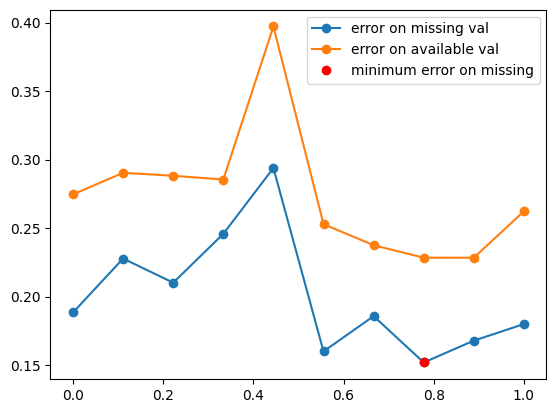

In [ ]:
plt.plot(p_dropout, dict_perf["error on missing val"], "-o", label = "error on missing val")
plt.plot(p_dropout, dict_perf["error on available val"], "-o", label = "error on available val")
plt.plot(p_best, np.min(dict_perf["error on missing val"]), "ro", label = "minimum error on missing")
plt.legend()

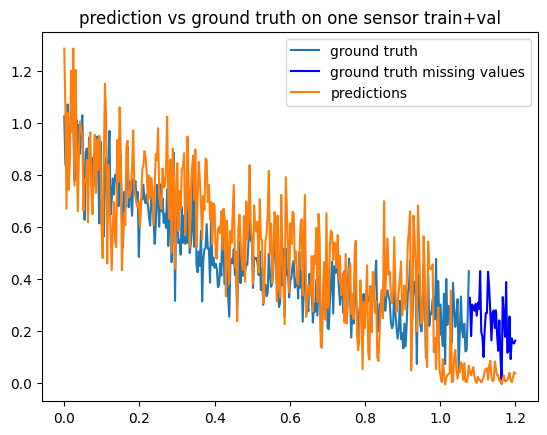

In [ ]:
sen = 4
time_train = time[:train_size]
m = torch.stack(out_data_train[2])
pred = torch.stack(predictions).cpu().detach()
#targ = data_tot[:,sen,2].cpu().detach().numpy()
targ = velocity_train[:,sen].cpu().detach().numpy()
plt.plot(time_train[m[:,sen] != -float("Inf")],targ[m[:,sen]!=-float("Inf")], label = "ground truth")
plt.plot(time_train[m[:,sen] == -float("Inf")], targ[m[:,sen]==-float("Inf")], "b", label = "ground truth missing values")
plt.plot(time_train, pred[:,sen], label = "predictions")
plt.title("prediction vs ground truth on one sensor train+val")
plt.legend()


In [ ]:
out_data_train_val[1][0].shape

torch.Size([30])

# Retrain with best dropout on train and validation set

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

args_dict = Namespace({
        'feats_per_node': 3,
        'layer_1_feats': 32,
        'layer_2_feats': 32,
        'layer_3_feats': 16,
        }) # output dim

activation = nn.ReLU()

A_list_train_val = [a.to(device) for a in out_data_train_val[0]]
mask_list_train_val = [m.to(device) for m in out_data_train_val[2]]
velocity_train_val = data_vel[:train_size+val_size,:].to(device)
missing_nodes_train_val = [mn.to(device) for mn in out_data_train_val[3]]

tt_train_val = torch.tensor(time[:train_size+val_size], dtype = torch.float32).to(device)
xx = torch.tensor(x_node, dtype = torch.float32).to(device)
g_train_val = torch.stack(torch.meshgrid(tt_train_val, xx)).reshape(2,-1).T.requires_grad_(True).to(device)
vel_train_val = out_data_train_val[1].to(device)

#data_tot = data_tot.to(device)

n_nodes = len(x_node)

model = PredictionEGCN(args_dict, activation, n_nodes, device, 0.5, 3).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
model.train()


# Move model to device
# model = PredictionEGCN(args_dict, activation, n_nodes, device).to(device)


# #model = simpleNN(args_dict, activation, device).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# model.train()

prev_epoch_loss = torch.tensor(float("Inf"))
counter = 0

n_epochs = 30

lambda_physics = 0.3

train_data_loss = []
train_loss = []
test_loss = []
train_loss_physics = []

nu = 0.1

data_loss_list = []


for epoch in range(n_epochs):
    epoch_loss = 0
    predictions_t = []

    optimizer.zero_grad()

    #predictions, weights = model.forward(A_list_train_val, g_train_val, vel_train_val, mask_list_train_val)
    predictions, weights, embed_mat = model.forward(A_list_train_val, g_train_val, vel_train_val, mask_list_train_val)

    uu = torch.stack(predictions).reshape(-1)


    du_dg = torch.autograd.grad(
          inputs=g_train_val,
          outputs=uu,
          grad_outputs=torch.ones_like(uu),
          retain_graph=True,
          create_graph=True
      )[0]

    du_dt = du_dg[:,0]
    du_dx = du_dg[:,1]

    du_dxx = torch.autograd.grad(
          inputs=g_train_val,
          outputs=du_dg,
          grad_outputs=torch.ones_like(du_dg),
          retain_graph=True,
          create_graph=True
      )[0][:, 0]



    f = uu*du_dx + du_dt - nu*du_dxx

    physics_loss = F.mse_loss(f,torch.zeros_like(f))

    train_loss_physics.append(physics_loss.detach().item())


    data_loss = 0
    missing_train = 0
    count_missing = 0
    count_available = 0
    available_train = 0
    imputation_loss = 0


    # for i in range(train_size+val_size):

    #   mask = mask_list_train_val[i].clone()
    #   mask[mask==-float("Inf")]=0

    #   data_loss += F.mse_loss(predictions[i][mask==1],velocity_train_val[i,:][mask==1])

    #   if len(torch.where(mask == 1)[0]) != 0:
    #     available_train += F.mse_loss(predictions[i][mask==1],velocity_train_val[i,mask==1])
    #     count_available += 1

    #   if len(torch.where(mask == 0)[0]) != 0:
    #     missing_train += F.mse_loss(predictions[i][mask==0],velocity_train_val[i,mask==0])
    #     count_missing += 1

    #   if epoch == n_epochs-1:
    #     data_loss_list.append(data_loss)

    # data_mean_loss = data_loss/len(time)
    # missing_train = missing_train/count_missing
    # available_train = available_train/count_available

    # total_loss = data_mean_loss * (1-lambda_physics) + physics_loss*lambda_physics

    # train_data_loss.append(data_mean_loss.detach().item())
    # train_loss.append(total_loss.detach().item())

    # total_loss.backward()
    # optimizer.step()


    for i in range(train_size+val_size):
        mask = mask_list_train_val[i].clone()
        mask[mask==-float("Inf")] = 0

        # Data loss for available values
        data_loss += F.mse_loss(predictions[i][mask==1], velocity_train_val[i,:][mask==1])

        # Imputation for missing values during training
        if missing_nodes_train_val[i].shape[0] != 0:
            # similarity_nodes = torch.cdist(embed_mat[i], embed_mat[i])
            # #similarity_nodes = torch.mm(embed_mat[i], embed_mat[i].T)/(torch.norm(embed_mat[i],dim = 1).unsqueeze(1)*torch.norm(embed_mat[i],dim = 1).unsqueeze(0))
            # similarity_nodes.fill_diagonal_(-float('inf'))
            # _, nearest_indices = torch.topk(similarity_nodes, k=3, largest=True)

            # for idx in missing_nodes_train_val[i]:
            #     # Compute imputed value using embeddings
            #     neighbor_embeddings = embed_mat[i][nearest_indices[idx]]
            #     current_embedding = embed_mat[i][idx]

            #     # Soft attention weights based on embedding similarity
            #     attention_weights = F.softmax(-torch.cdist(
            #         current_embedding.unsqueeze(0),
            #         neighbor_embeddings
            #     ).squeeze(), dim=0)

            #     # Weighted prediction
            #     imputed_value = (predictions[i][nearest_indices[idx]] * attention_weights).sum()

            #     # Add to imputation loss
            imputation_loss += F.mse_loss(predictions[i][mask==0], velocity_train_val[i][mask==0])
            count_missing += 1

    data_mean_loss = data_loss / (train_size+val_size)
    imputation_mean_loss = imputation_loss / count_missing if count_missing > 0 else 0

    # Combined loss with all components
    lambda_imputation = 0.2  # Weight for imputation loss
    total_loss = (data_mean_loss * 0.45 +
                 physics_loss * 0.1 +
                 imputation_mean_loss * 0.45)

    total_loss.backward()
    optimizer.step()

    if epoch % 2 == 0:
        print(f"Epoch {epoch}")
        print(f"Data Loss: {data_mean_loss:.6f}")
        print(f"Physics Loss: {physics_loss:.6f}")
        print(f"Imputation Loss: {imputation_mean_loss:.6f}")

    # with torch.no_grad():

    #     model.eval()

    #     predictions_eva, weights_eva, embed_mat_eva = model.forward(A_list_train_val, g_train_val, vel_train_val, mask_list_train_val)

    #     error_on_missing = 0

    #     for i in range(len(predictions_eva)):

    #       if missing_nodes_train_val[i].shape[0] != 0:

    #         for idx in missing_nodes_train_val[i]:

    #             predictions_eva[i][idx] = predictions_eva[i][nearest_indices[idx]].mean()

    #             #vel_train_val[i][idx] = predictions_eva[i][nearest_indices[idx]].mean()

    #         error_on_missing += F.mse_loss(predictions_eva[i][missing_nodes_train_val[i]], velocity_train_val[i][missing_nodes_train_val[i]])

    #     error_on_missing = error_on_missing/len(missing_nodes_train_val)




    # epoch_loss += data_mean_loss.item()

    # if epoch % 2 == 0:
    #     print(f"Epoch {epoch}, Data Loss: {data_mean_loss.item():.6f}, physic_loss: {physics_loss.item()}, error on missing train: {error_on_missing}, error on available: {available_train}")

Epoch 0
Data Loss: 0.169792
Physics Loss: 0.010566
Imputation Loss: 0.161085
Epoch 2
Data Loss: 0.159842
Physics Loss: 0.000201
Imputation Loss: 0.139498
Epoch 4
Data Loss: 0.138141
Physics Loss: 0.004010
Imputation Loss: 0.078523
Epoch 6
Data Loss: 0.112597
Physics Loss: 0.004427
Imputation Loss: 0.055436
Epoch 8
Data Loss: 0.076065
Physics Loss: 0.012046
Imputation Loss: 0.053226
Epoch 10
Data Loss: 0.078516
Physics Loss: 0.004728
Imputation Loss: 0.034061
Epoch 12
Data Loss: 0.047181
Physics Loss: 0.017887
Imputation Loss: 0.049917
Epoch 14
Data Loss: 0.045767
Physics Loss: 0.009076
Imputation Loss: 0.024348
Epoch 16
Data Loss: 0.036387
Physics Loss: 0.007916
Imputation Loss: 0.025103
Epoch 18
Data Loss: 0.035688
Physics Loss: 0.011179
Imputation Loss: 0.031672
Epoch 20
Data Loss: 0.034356
Physics Loss: 0.004311
Imputation Loss: 0.025987
Epoch 22
Data Loss: 0.031929
Physics Loss: 0.007207
Imputation Loss: 0.025758
Epoch 24
Data Loss: 0.028211
Physics Loss: 0.006881
Imputation Loss: 

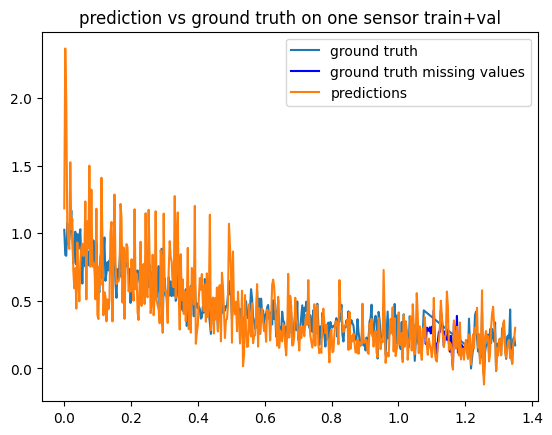

In [ ]:
sen = 4
time_train = time[:train_size+val_size]
m = torch.stack(out_data_train_val[2])
pred = torch.stack(predictions).cpu().detach()
#targ = data_tot[:,sen,2].cpu().detach().numpy()
targ = velocity_train_val[:,sen].cpu().detach().numpy()
plt.plot(time_train[m[:,sen] != -float("Inf")],targ[m[:,sen]!=-float("Inf")], label = "ground truth")
plt.plot(time_train[m[:,sen] == -float("Inf")], targ[m[:,sen]==-float("Inf")], "b", label = "ground truth missing values")
plt.plot(time_train, pred[:,sen], label = "predictions")
plt.title("prediction vs ground truth on one sensor train+val")
plt.legend()


In [ ]:
def plot_3d_solution(x, t, u_pred, u_real):
    """Create multiple 3D visualizations of the solution"""
    # Create a meshgrid for plotting
    X, T = np.meshgrid(x, t)

    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 7))
    axes = [fig.add_subplot(1, 2, i+1, projection='3d') for i in range(2)]

    # Plot predictions and ground truth
    for i, (ax, u) in enumerate(zip(axes, [u_pred, u_real])):
        surf = ax.plot_surface(X, T, u, cmap='viridis', edgecolor='none')
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        ax.set_zlabel('u')
        ax.set_title(f'Surface Plot: {"Predictions" if i == 0 else "Ground Truth"}')

        # Add colorbar to the side of the respective subplot
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

        # Adjust view angles
        ax.view_init(elev=30, azim=45)

    plt.tight_layout()
    plt.show()


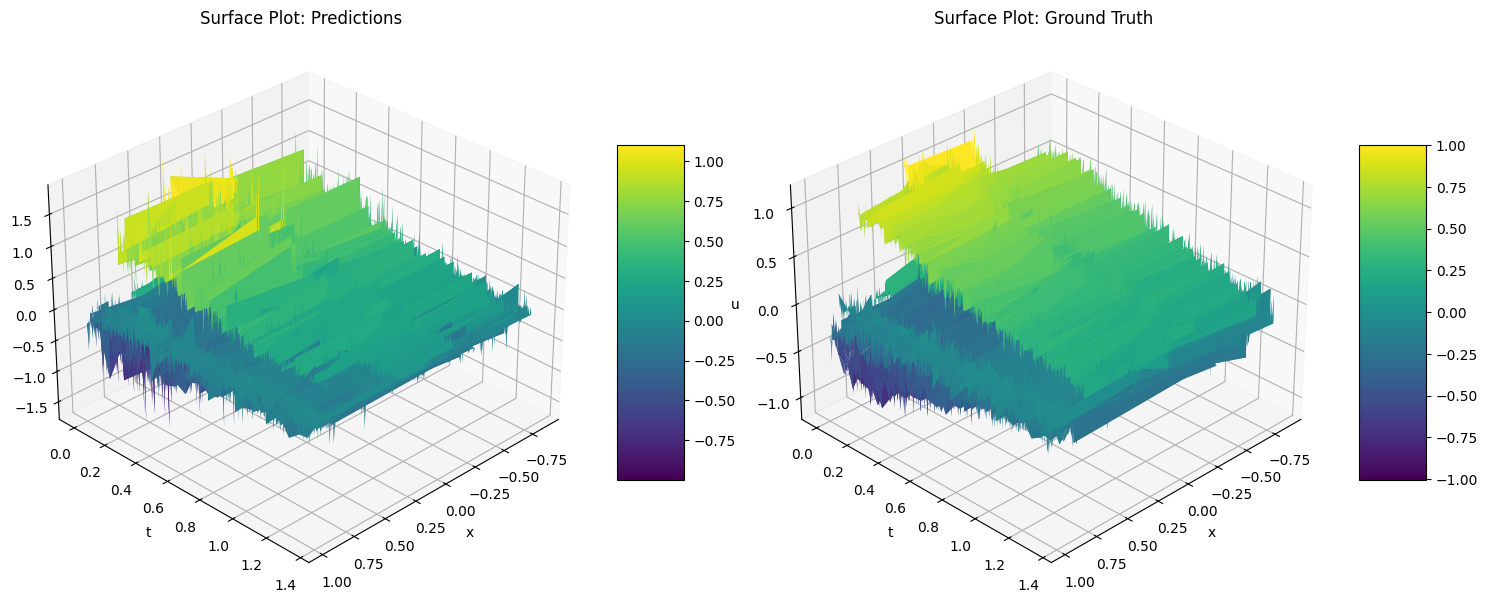

In [ ]:
plot_3d_solution(x_node, time[:train_size+val_size], pred, velocity_train_val)

# Test Set

In [ ]:


A_list_test = [a.to(device) for a in out_data_test[0]]
mask_list_test = [m.to(device) for m in out_data_test[2]]
velocity_test = data_vel[-test_size:,:].to(device)

tt_test = torch.tensor(time[-test_size:], dtype = torch.float32).to(device)
xx = torch.tensor(x_node, dtype = torch.float32).to(device)
g_test = torch.stack(torch.meshgrid(tt_test, xx)).reshape(2,-1).T.requires_grad_(True).to(device)
vel_test = out_data_test[1].to(device)


missing_test = 0
count_missing = 0
count_available = 0
available_test = 0
data_loss_test = 0

error_on_missing = []
error_on_available = []

with torch.no_grad():
    model.eval()
    predictions_test, weights_test, _ = model.forward(A_list_test, g_test, vel_test, mask_list_test)

    for i in range(test_size):

      mask = mask_list_test[i].clone()
      mask[mask==-float("Inf")]=0

      data_loss_test += F.mse_loss(predictions_test[i],velocity_test[i,:])

      if len(torch.where(mask == 0)[0]) != 0:
        error_m = F.mse_loss(predictions_test[i][mask==0],velocity_test[i,mask==0])
        error_on_missing.append(error_m)
        missing_test  += error_m
        count_missing += 1

      elif len(torch.where(mask == 1)[0]) != 0:
        error_a = F.mse_loss(predictions_test[i][mask==1],velocity_test[i,mask==1])
        error_on_available.append(error_a)
        available_test += error_a
        count_available += 1

    missing_test = missing_test/count_missing
    available_test = available_test/count_available

    data_loss_test = data_loss_test/len(time)

In [ ]:
def IQR(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    return IQR

In [ ]:
iqr_missing = IQR(error_on_missing)
iqr_available = IQR(error_on_available)

In [ ]:
iqr_missing

0.05968987615779042

In [ ]:
iqr_available

0.09702745918184519

# Results

In [ ]:
df_results_egcn_physics = pd.DataFrame({
    "set": ["train", "test"],
    "error on NON missing data": [data_mean_loss.item(), available_test.item()],
    "error on missing data": [imputation_mean_loss.item(), missing_test.item()]})
df_results_egcn_physics.set_index("set",inplace = True)

In [ ]:
df_results_egcn_physics

,error on NON missing data,error on missing data
set,,
train,0.027450,0.023416
test,0.479388,0.060908


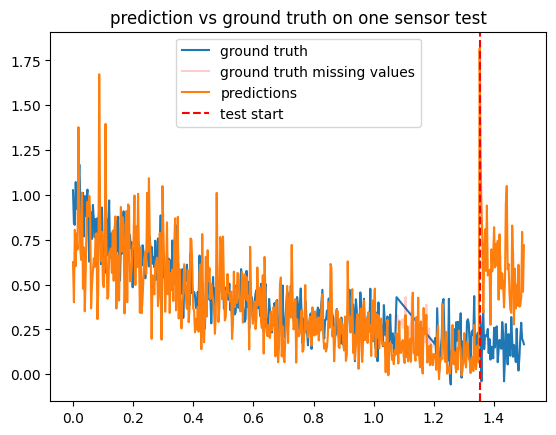

In [ ]:
sen = 4
m_test = torch.stack(out_data_test[2])
m_train_val = torch.stack(out_data_train_val[2])
m = torch.cat((m_train_val, m_test), dim = 0)
pred_test = torch.stack(predictions_test).cpu().detach()
pred_train_val = torch.stack(predictions).cpu().detach()
pred = torch.cat((pred_train_val, pred_test), dim = 0)
#targ = data_tot[:,sen,2].cpu().detach().numpy()
targ = data_vel[:,sen].cpu().detach().numpy()
plt.plot(time[m[:,sen] != -float("Inf")],targ[m[:,sen]!=-float("Inf")], label = "ground truth")
plt.plot(time[m[:,sen] == -float("Inf")], targ[m[:,sen]==-float("Inf")], "r", alpha = 0.2, label = "ground truth missing values")
plt.plot(time, pred[:,sen], label = "predictions")
plt.axvline(x=time[train_size+val_size], color='r', linestyle='--', label='test start')
plt.title("prediction vs ground truth on one sensor test")
plt.legend()